# **HW #13 Code Submission**

## Connal Boyd
### 11/21/2021

This notebook can be used as a guide for generating a one and two week streamflow forecast for the Verde River. Note that this notebook contains just one of many ways to create values for a hydrologic forecast.

In the past I have generally relied on intuition based on observation of general climate trends and weather patterns as well as some cursory analysis of historical streamflow data to generate streamflow forecasts. Over time, my forecasts have begun to include much more analysis from graphing of historical data and linear regression modeling. Generating forecasts using python has helped me to develop the computer tools necessary for understanding data in the modern world, and has made it easier to work with large datasets from a variety of online sources. Although my forecasts have been less than accurate throughout the semester, I have enjoyed the process of learning how to code each new forecast attempt. Additionally, I have been able to see my python skills grow as I have progressed through the semester. 

Insert packages for use throughout the forecast code.

In [212]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import fiona
import contextily as ctx
import xarray as xr
import shapely
from shapely.geometry import Point
from netCDF4 import Dataset
import datetime
from sklearn.linear_model import LinearRegression
from urllib.request import urlretrieve

### Constructing a Map of the Forecast Gage and Surrounding Cities

Our forecasts are based on flow data taken from the Verde River gage near Camp Verde in Arizona. I constructed a simple map to show the location of the gage in relation to the closest cities.

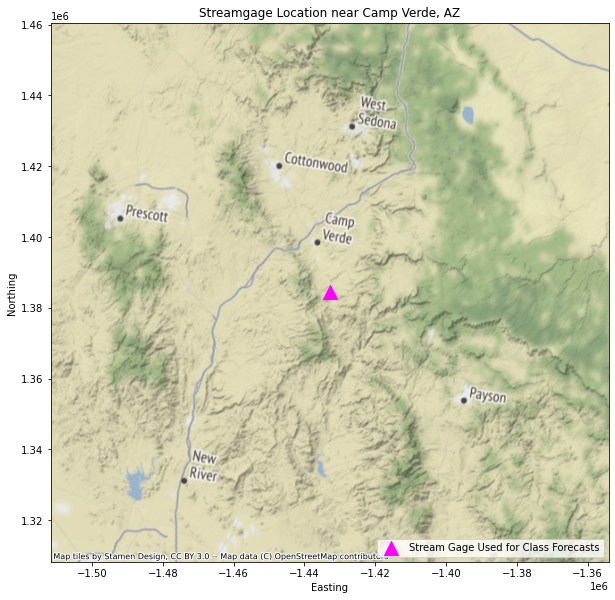

In [213]:
# Access stream gages data
gages_file = os.path.join('..', 'data', 'Shapefiles_and_GDBs',
                          'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(gages_file)

# Create smaller geodataframe for just the AZ stream gages
gages_AZ = gages[gages['STATE'] == 'AZ']
# Create geodataframe of just our station
verde_station = gages_AZ[gages_AZ['STAID'] == '09506000']

# Plot gage layer, creating map
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor("white")
ax.set(title='Streamgage Location near Camp Verde, AZ', xlabel='Easting',
       ylabel='Northing')
layer1 = verde_station.plot(ax=ax, color='magenta', marker='^', markersize=200,
                            label='Stream Gage Used for Class Forecasts',
                            zorder=1)
ctx.add_basemap(ax, crs=gages_AZ.crs)
ax.legend(loc='lower right')
plt.show()

## Plot of Last Week's Streamflow Behavior


In [214]:
# Import streamflow data
flow_url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb" \
              + "&site_no=09506000&referred_module=sw&period=" + \
                     "&begin_date=1989-01-01&end_date=2021-11-20"
flow_data = pd.read_table(flow_url, sep='\t', skiprows=30,
                          names=['agency_cd', 'site_no', 'datetime', 'flow',
                                 'code'], parse_dates=['datetime'],
                          index_col=['datetime'])
# Assign additional datetime columns for use in plotting throughout the code
flow_data['month'] = pd.DatetimeIndex(flow_data.index).month
flow_data['day'] = pd.DatetimeIndex(flow_data.index).day
flow_data['year'] = pd.DatetimeIndex(flow_data.index).year

Create a plot for the last week of streamflow using the following code:

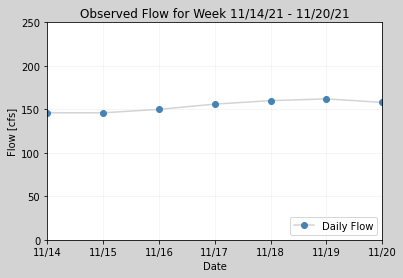

In [215]:
# Create plot of streamflow behavior during last forecast period
date_format = mdates.DateFormatter("%m/%d")
fig, ax = plt.subplots()
ax.plot(flow_data['flow'], label='Daily Flow', marker='o',
        color='lightgray',
        markerfacecolor='steelblue',
        markeredgecolor='steelblue')
ax.set(title="Observed Flow for Week 11/14/21 - 11/20/21", xlabel="Date",
       ylabel="Flow [cfs]", ylim=[0, 250],
       xlim=[datetime.date(2021, 11, 14), datetime.date(2021, 11, 20)])
ax.xaxis.set_major_formatter(date_format)
ax.grid(None, 'major', 'both', alpha=0.15)
ax.legend(loc='lower right')
fig.set(facecolor='lightgrey')
plt.show()

The highest daily flow occurred on November 19th. Further details of the weekly flow can be seen using the following code:

In [216]:
print('Flow during the last forecast period:')
last_week = flow_data[['flow']].tail(7)
print(last_week)
print('Avg flow for last week was:', last_week.mean())

Flow during the last forecast period:
             flow
datetime         
2021-11-14  146.0
2021-11-15  146.0
2021-11-16  150.0
2021-11-17  156.0
2021-11-18  160.0
2021-11-19  162.0
2021-11-20  158.0
Avg flow for last week was: flow    154.0
dtype: float64


## Review of Previous Forecasts

For previous forecasts I have used the function below to analyze the previous five years of flow for a forecast period and create one and two week forecasts from the results. The example below is for the previous week's forecast window.

In [217]:
def historical_weekly_flow(startyear, endyear, month, first_fcst_st_day,
                           first_fcst_end_day, scnd_fcst_st_day,
                           scnd_fcst_end_day):
    '''Creates line plots of flow for any streamflow forecast period.

        This function will plot a line for each year within
        the forecast window that is specified by the input parameters.

        Parameters
        ----------
        startyear: int
                Input the beginning year of the time frame desired.
                Ex: Want flows from 1990-1997? startyear=1990
        endyear: int
                Input the ending year of the time frame desired.
                Ex: Want flows from 1990-1997? endyear=1997
        month: int
                Input the month of flows desired.
                Ex: Want flows from each April 1990-1997? month=4
        first_fcst_st_day: int
                Input the starting day of the 1 week forecast window.
                Ex: Want flows for 03/10/89-03/16/89? first_fcst_st_day=10
        first_fcst_end_day: int
                Input the ending day of the 1 week forecast window.
                Ex: Want flows for 03/10/89-03/16/89? first_fcst_end_day=16
        scnd_fcst_st_day: int
                Input the starting day of the 2 week forecast window.
                Ex: Want flows for 03/17/89-03/23/89? scnd_fcst_st_day=17
        scnd_fcst_end_day: int
                Input the ending day of the 1 week forecast window.
                Ex: Want flows for 03/17/89-03/23/89? scnd_fcst_end_day=23

        Returns
        ------
        plt.show(): graph
                Function creates plot of all flows meeting function
                criteria within time frame.
        fig: figure variable
                Function returns figure variable so users can specify
                additional plot attributes for the generated graph
                during individual use of the function.
        '''

    line_pal = sns.color_palette('viridis', 5)
    clr_choose = 0
    fig, ax = plt.subplots(2, 1)
    for i in range(startyear, endyear):
        fcst_1_plot = flow_data[(flow_data.index.year == i) &
                           (flow_data.index.month == month) &
                           (flow_data.index.day >= first_fcst_st_day)
                           & (flow_data.index.day <= first_fcst_end_day)]
        ax[0].plot(fcst_1_plot.index.day, fcst_1_plot['flow'],
                   color=line_pal[clr_choose], label=i)
        ax[0].set(title='Flow History of 1 Week Forecast Window',
                  ylabel='Flow (cfs)')
        ax[0].legend(loc='upper left')
        ax[0].grid(None, 'major', 'both', alpha=0.15)
        fcst_2_plot = flow_data[(flow_data.index.year == i) &
                           (flow_data.index.month == month) &
                           (flow_data.index.day >= scnd_fcst_st_day) &
                           (flow_data.index.day <= scnd_fcst_end_day)]
        ax[1].plot(fcst_2_plot.index.day, fcst_2_plot['flow'],
                   color=line_pal[clr_choose], label=i)
        ax[1].set(title='Flow History of 2 Week Forecast Window',
                  xlabel='Day in Month', ylabel='Flow (cfs)')
        ax[1].grid(None, 'major', 'both', alpha=0.15)
        clr_choose = clr_choose+1
    fig.set(facecolor='lightgrey', tight_layout=True)
    plt.show()

    return fig

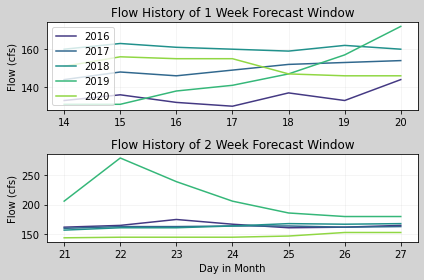

In [218]:
start_year = 2016
end_year = 2021
fcst_month = 11
one_wk_st = 14
one_wk_end = 20
two_wk_st = 21
two_wk_end = 27

fig = historical_weekly_flow(start_year, end_year, fcst_month, one_wk_st,
                             one_wk_end, two_wk_st, two_wk_end)

While this method provided good insight, I recently began using linear regression to estimate my forecast values instead. In order to determine which subset of the data to perform linear regression on, I looked at the average November flows from year to year.

## Plot of Average November Flow from Year to Year
A plot of the average flow during the month of November from year to year helps to showcase the behavior of flows over time.

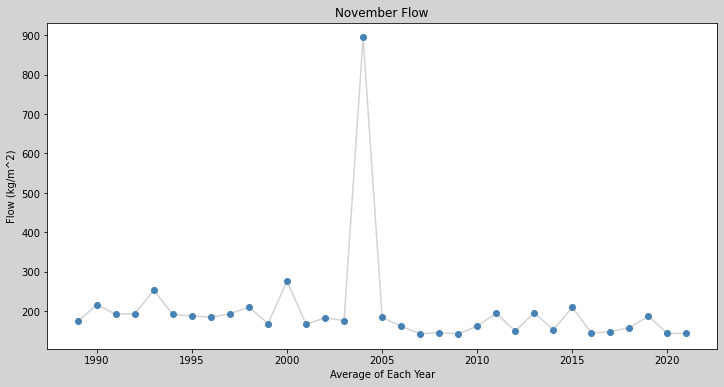

In [219]:
# Create smaller dataframe of just november flows
nov_flow = flow_data[flow_data.index.month == 11]
# Plot november average flows
nov_mean = nov_flow.groupby('year')['flow'].mean()
fig, ax = plt.subplots(figsize=(12, 6))
nov_mean.plot.line(marker="o",
                    ax=ax,
                    color="lightgray",
                    markerfacecolor="steelblue",
                    markeredgecolor="steelblue")
ax.set(title="November Flow",
       xlabel="Average of Each Year",
       ylabel="Flow (kg/m^2)")
fig.set(facecolor='lightgrey')
plt.show()

The flow in 2004 was much higher than any other year, but even from year to year the flow showed a high amount of variability. Since 2020 and 2021 have had similar flows for the month of November, only these months were included in the following regression analysis.

## Regression Analysis
Add in the air temperature data and precipitation data.

In [220]:
# Add in air temperature data
temp_path = os.path.join('..', '..', 'working_drafts', 'data', 'Hierarchical_Data',
                         '1989_2021_NCEP_AirTemp_Data_v2.nc')
temp = xr.open_dataset(temp_path)
temp

lat = temp['air']['lat'].values[0]
lon = temp['air']['lon'].values[0]

point_temp = temp['air']
temp_df = point_temp.to_dataframe()
temp_df = temp_df.groupby('time').mean()
temp_df['year'] = pd.DatetimeIndex(temp_df.index).year
temp_df['month'] = pd.DatetimeIndex(temp_df.index).month
temp_df['day'] = pd.DatetimeIndex(temp_df.index).day
temp_df.drop(temp_df[temp_df['year'] < 2020].index, inplace=True)


In [221]:
# Add in precipitation rate data
precip_path = os.path.join('..', '..', 'working_drafts', 'data', 'Hierarchical_Data',
                           '1989_2021_NCEP_PrecipRate_Data_v5.nc')
precip = xr.open_dataset(precip_path)
precip
point_precip = precip['prate']
precip_df = point_precip.to_dataframe()
precip_df = precip_df.groupby('time').mean()
precip_df['year'] = pd.DatetimeIndex(precip_df.index).year
precip_df['month'] = pd.DatetimeIndex(precip_df.index).month
precip_df['day'] = pd.DatetimeIndex(precip_df.index).day
precip_df.drop(precip_df[precip_df['year'] < 2020].index, inplace=True)


Do some data configuration to prepare the streamflow, air temperature, and precipitation data for use in the regression model.

In [222]:
# Drop data before 2020
flow_drop = flow_data.drop(flow_data[flow_data.index.year < 2020].index, inplace=True)

precip_df
temp_df
# Drop the last value of the flow data since the precip and temp data
# do not go to 11/20
flow_data = flow_data[:-1]

# Combine streamflow, precip, and air temp into one dataframe
# Note that these three data types are at slightly different spatial resolutions
flow_data['precip'] = (precip_df['prate']-np.mean(precip_df['prate']))/np.std(precip_df['prate'])
flow_data['temp'] = (temp_df['air']-np.mean(temp_df['air']))/np.std(temp_df['air'])


Create the regression model and output the 1 and 2 week forecast values.

coefficient of determination: 0.64
intercept: 164.09
slope: [ 3.6000e-01  6.1626e+02 -1.4820e+01]
1 Wk Forecast: 157.8
2 Wk Forecast: 136.5


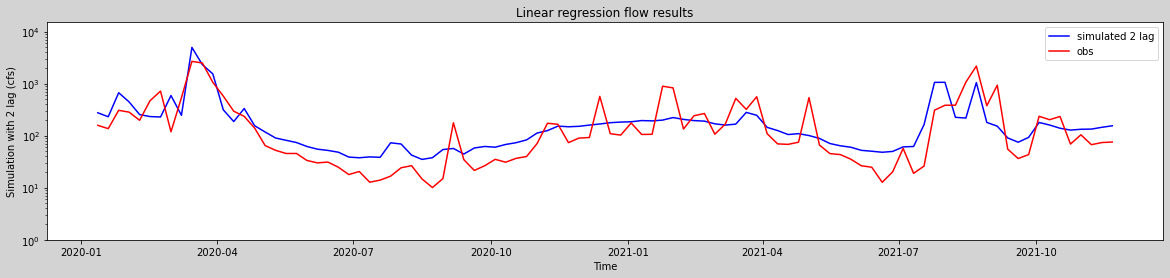

In [223]:
# Build an autoregressive model
flow_mean = flow_data.resample('W').mean()
flow_mean['flow_tm1'] = flow_mean['flow'].shift(1)

# Traing the model using the flow, precip, and air temp data
train = flow_mean[1:][['flow', 'flow_tm1' , 'precip', 'temp']]

# Build a linear regression model
model = LinearRegression()
x = train[['flow_tm1', 'precip', 'temp']] 
y = train['flow'].values
model.fit(x, y)

# Results of the model
r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))

# Print the intercept and the slope
print('intercept:', np.round(model.intercept_, 2))
print('slope:', np.round(model.coef_, 2))

# Model forecast predictions
prediction = model.predict(train[['flow_tm1', 'precip', 'temp']])
print("1 Wk Forecast:", round(prediction[0], 1))
print("2 Wk Forecast:", round(prediction[1], 1))

# Line plot comparison of predicted and observed flows
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(flow_mean.index[1:], flow_mean['flow'][1:], color='blue',
        label='simulated 2 lag')
ax.plot(flow_mean.index[1:], prediction, color='red', label='obs')
ax.set(title="Linear regression flow results", xlabel="Time",
       ylabel="Simulation with 2 lag (cfs)",
       yscale='log', ylim=(1, 15000))
ax.legend()
fig.set(facecolor='lightgray')
plt.show()

## Compare to Historical Data

Now that we have estimates for the 1 and 2 week forecast values from our regression model, we can examine whether those values are reasonable based on past data.

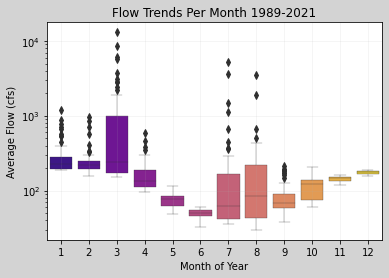

In [224]:
# Create a box plot to examine past data
fig, ax = plt.subplots()
ax = sns.boxplot(x=flow_data.month, y=flow_data['flow'], palette='plasma', data=flow_data,
                 linewidth=0.3)
ax.set(title='Flow Trends Per Month 1989-2021', yscale='log', xlabel='Month of Year', ylabel='Average Flow (cfs)')
ax.grid(None,'major','both', alpha= 0.15)
fig.set(facecolor='lightgrey')
plt.show()

By looking at the box plot of previous data, we can see that the departure of flows from the mean is rather small. The boxplot places most November flows in the 150 cfs range so our regression model values are reasonable.

Each of these three notebooks helped me to better understand the structure of a jupyter notebook and provided context for the general flow I should be striving for. I used these to guide my construction of my jupyter notebook.

https://ocefpaf.github.io/python4oceanographers/blog/2015/02/16/utide/)

http://earthpy.org/analyzing-whale-tracks.html

https://nbviewer.org/github/carljv/Will_it_Python/blob/master/ARM/ch5/arsenic_wells_switching.ipynb


**Note: I wanted to include a table of contents like this notebook, but I could not figure out how they did it.**

https://nbviewer.org/github/demotu/BMC/blob/master/notebooks/Transformation2D.ipynb